![img](hhl_model.jpeg)

In [1]:
import pennylane as qml
import numpy as np

# Esta celda es el conjunto de operaciones necesarias para implementar la división 

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
        
def substract_m_n(wires_m, wires_n):
    # |m>|n> ->  |m - n> |n>
    
    qml.QFT(wires = wires_m)
    
    
    for i in range(len(wires_n)):
        qml.ctrl(add_k_fourier, control=wires_n[i])(-2 **(len(wires_n) - i - 1), wires_m)
        
    qml.adjoint(qml.QFT)(wires = wires_m)

def is_greater(wires_m, wires_n, wires_aux, wires_target):
    
    wires_m_aux = [wires_aux] + list(wires_m)
    substract_m_n(wires_m_aux, wires_n)
    
    qml.PauliX(wires = wires_aux)
    qml.CNOT(wires = [wires_aux, wires_target])
    qml.PauliX(wires = wires_aux)
    
    qml.adjoint(substract_m_n)(wires_m_aux, wires_n)
    

def division(wires_dividendo, wires_divisor, wires_aux_dividendo, wires_solucion, wires_aux):
    
    wires_dividendo_totales = wires_aux_dividendo + wires_dividendo
    
    for i in range(len(wires_solucion)):
        window = wires_dividendo_totales[i - 1: len(wires_divisor)+ i]
        if i == 0:
            window = wires_dividendo_totales[0: len(wires_divisor)]
        
        is_greater(window, wires_divisor, wires_aux, wires_solucion[i])
        qml.ctrl(substract_m_n, control = wires_solucion[i])(window, wires_divisor)

In [2]:
# Subrutina del HHL

import scipy

A = 1/64 * np.array([[15, 9, 5, -3],
                       [9, 15, 3, -5],
                       [5, 3, 15, -9],
                       [-3, -5, -9, 15]])

U = scipy.linalg.expm(2 * np.pi * 1j * A)


dev = qml.device("default.qubit", wires = 21)

wires_b = [0,1]
wires_divisor = [2,3,4,5]
wires_solucion = [11,12,13,14,15]
wires_dividendo = [6,7,8,9,10]
wires_aux_window = [16,17,18]
aux_div = 19
wire_rotacion = 20

def qpe_division():
    qml.QuantumPhaseEstimation(U, wires_b, wires_divisor)
    qml.PauliX(wires = wires_dividendo[0])
    division(wires_dividendo, wires_divisor, wires_aux_window, wires_solucion, aux_div)

@qml.qnode(dev)
def circuit():

    #inicializamos b
    qml.Hadamard(wires = 0)
    qml.Hadamard(wires = 1)

    qpe_division()

    for i in range(len(wires_solucion)):

        C = 1/2 ** (len(wires_solucion)- 1)
        qml.CRY(2 *np.arccos(2 ** (len(wires_solucion)-i-1) * C), wires = [wires_solucion[i], wire_rotacion])
        
    qml.PauliX(wires = wire_rotacion)
    
    qml.adjoint(qpe_division)()

    return qml.density_matrix(wires = wires_b +  [wire_rotacion])

In [3]:
import functools as ft

def qubit_postselect_dm(meas_outputs, wires, in_state):
    
    num_wires = int(np.log2(len(in_state)))
    arr = [np.identity(2) for _ in range(num_wires)]
    for i in range(len(wires)):
        if meas_outputs[i]=='0':
            arr[int(wires[i])]=np.array([1,0])
        elif meas_outputs[i]=='1':
            arr[int(wires[i])]=np.array([0,1])
            
    projector = ft.reduce(np.kron,arr)
    out_state = np.linalg.multi_dot([projector, in_state, projector.T])
    out_state = out_state/np.trace(out_state)
    
    return [out_state[i][i] for i in range(len(out_state))]

In [4]:
dm = circuit()
output = qubit_postselect_dm("1", [2], dm)
print(output)

/Users/guille/Documents/GitHub/pennylane/pennylane/qnode.py:823: UserWarning: The device was switched during the call of the QNode, to avoid this behaviour definean interface argument instead of auto.
  warnings.warn(


[(0.002941176470605185+2.3366182719901103e-34j), (0.14411764705886757+3.614998646227333e-33j), (0.35588235294116893-1.5558228322110126e-33j), (0.49705882352935826-2.2928376412153303e-33j)]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


<BarContainer object of 4 artists>

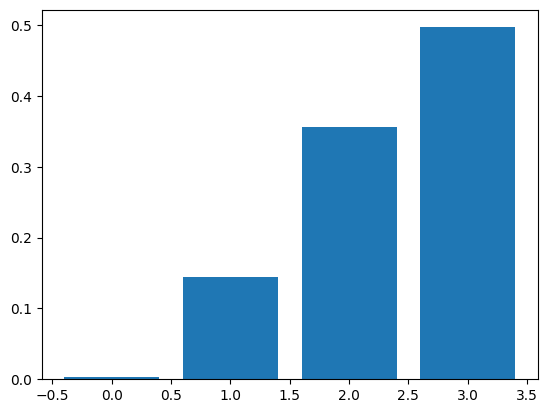

In [5]:
import matplotlib.pyplot as plt

plt.bar(range(len(output)), output)

<BarContainer object of 4 artists>

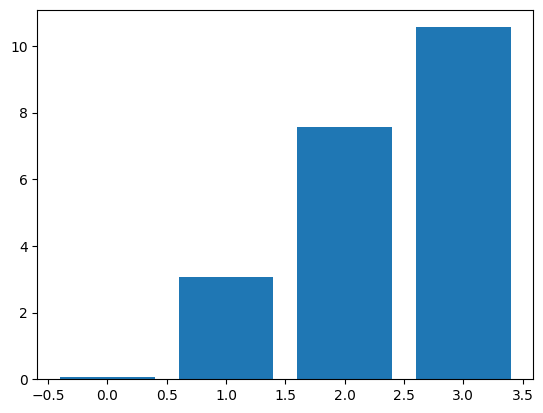

In [6]:
solucion = (1/4 * np.array([-1, 7 ,11, 13])) ** 2

plt.bar(range(len(solucion)), solucion)